# 03. Clasificación de Imágenes con PyTorch

## Parte 3 de "Aprendizaje profundo con Pytorch: de cero a GAN"

Esta serie de didácticas es una introducción práctica y amena para principiantes en aprender en profundidad con la ayuda de [PyTorch](https://pytorch.org), una biblioteca de recursos de neuronas de código abierto. Estos tutoriales adoptan un enfoque práctico centrado en la codificación. La mejor manera de aprender hardware es ejecutar el código y experimentarlo usted mismo.

Este tutorial cubre los siguientes temas:
    
* Trabajar con imágenes en PyTorch (usando el conjunto de datos MNIST)
* Dividir un conjunto de datos en conjuntos de entrenamiento, validación y prueba
* Creación de modelos PyTorch con lógica personalizada mediante la ampliación de la clase `nn.Module`
* Interpretar los resultados del modelo como probabilidades utilizando Softmax y seleccionando etiquetas predichas
* Elegir una métrica de evaluación útil (precisión) y una función de pérdida (entropía cruzada) para problemas de clasificación
* Configuración de un ciclo de entrenamiento que también evalúa el modelo utilizando el conjunto de validación
* Probar el modelo manualmente en ejemplos seleccionados al azar* Guardar y cargar puntos de control del modelo para evitar volver a entrenar desde cero

## Cómo ejecutar el código

Este tutorial es un ejecutable [Jupyter notebook](https://jupyter.org) alojado en [Jovian](https://www.jovian.ai). Puede _ejecutar_ este tutorial y experimentar con los ejemplos de código de varias maneras: *usando recursos gratuitos en línea* (recomendado) o *en su computadora*.

## Opción 1: Ejecutar usando recursos en línea gratuitos (1-clic, recomendado)

La forma más fácil de comenzar a ejecutar el código es hacer clic en el botón **Ejecutar** en la parte superior de esta página y seleccionar **Ejecutar en Colab**. [Google Colab](https://colab.research.google.com) es una plataforma en línea gratuita para ejecutar portátiles Jupyter utilizando la infraestructura de nube de Google. También puede seleccionar "Ejecutar en Binder" o "Ejecutar en Kaggle" si tiene problemas para ejecutar el cuaderno en Google Colab.


## Opción 2: Ejecutar en su computadora localmente

Para ejecutar el código en su computadora localmente, deberá configurar [Python](https://www.python.org), descargar el cuaderno e instalar las bibliotecas requeridas. Recomendamos usar la distribución [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) de Python. Haga clic en el botón **Ejecutar** en la parte superior de esta página, seleccione la opción **Ejecutar localmente** y siga las instrucciones.

> **Cuadernos de Jupyter**: Este tutorial es un [Cuaderno de Jupyter](https://jupyter.org) - un documento hecho de _celdas_. Cada celda puede contener código escrito en Python o explicaciones en inglés sencillo. Puede ejecutar celdas de código y ver los resultados, por ejemplo, números, mensajes, gráficos, tablas, archivos, etc., instantáneamente dentro del cuaderno. Jupyter es una poderosa plataforma para la experimentación y el análisis. No tenga miedo de perder el tiempo con el código y romper cosas: aprenderá mucho al encontrar y corregir errores. Puede utilizar la opción de menú "Kernel > Reiniciar y borrar salida" o "Editar > Borrar salidas" para borrar todas las salidas y empezar de nuevo desde arriba.

## Trabajar con imágenes

En este tutorial, usaremos nuestro conocimiento existente de PyTorch y la regresión lineal para resolver un tipo de problema muy diferente: *clasificación de imágenes*. Usaremos la famosa [*Base de datos de dígitos escritos a mano del MNIST*](http://yann.lecun.com/exdb/mnist/) como nuestro conjunto de datos de entrenamiento. Consiste en imágenes en escala de grises de 28 px por 28 px de dígitos escritos a mano (0 a 9) y etiquetas para cada imagen que indican qué dígito representa. Aquí hay algunas imágenes de muestra del conjunto de datos:

![muestra-mnist](https://i.imgur.com/CAYnuo1.jpg)

Comenzamos instalando e importando `torch` y `torchvision`. `torchvision` contiene algunas utilidades para trabajar con datos de imagen. También proporciona clases auxiliares para descargar e importar conjuntos de datos populares como MNIST automáticamente.

In [5]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [6]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Cuando esta instrucción se ejecuta por primera vez, descarga los datos en el directorio `data/` al lado del cuaderno y crea un PyTorch `Dataset`. En ejecuciones posteriores, la descarga se omite porque los datos ya se han descargado. Vamos a comprobar el tamaño del conjunto de datos.

El conjunto de datos tiene 60 000 imágenes que usaremos para entrenar el modelo. También hay un conjunto de prueba adicional de 10 000 imágenes que se utilizan para evaluar modelos y reportar métricas en documentos e informes. Podemos crear el conjunto de datos de prueba usando la clase `MNIST` pasando `train=False` al constructor.

In [ ]:
test_dataset = MNIST(root='data/', train=False)

Veamos un elemento de muestra del conjunto de datos de entrenamiento.

In [9]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1A79439D198>, 5)

In [10]:
test_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1A79439D240>, 7)

Es un par, que consiste en una imagen de 28x28px y una etiqueta. La imagen es un objeto de la clase `PIL.Image.Image`, que forma parte de la biblioteca de imágenes de Python [Pillow](https://pillow.readthedocs.io/en/stable/). Podemos ver la imagen dentro de Jupyter usando [`matplotlib`](https://matplotlib.org/), la biblioteca de gráficos y gráficos de facto para la ciencia de datos en Python.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

La instrucción `%matplotlib inline` indica a Jupyter que queremos trazar los gráficos dentro del cuaderno. Sin esta línea, Jupyter mostrará la imagen en una ventana emergente. Las declaraciones que comienzan con `%` se denominan comandos mágicos y se utilizan para configurar el comportamiento del propio Jupyter. Puede encontrar una lista completa de comandos mágicos aquí: https://ipython.readthedocs.io/en/stable/interactive/magics.html.

Veamos un par de imágenes del conjunto de datos.

Label: 5


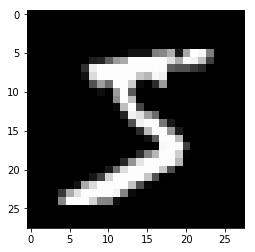

In [12]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


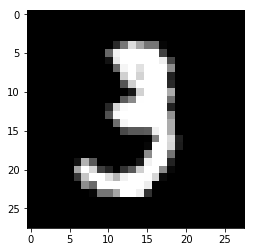

In [13]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

Es obvio que estas imágenes tienen un tamaño relativamente pequeño, y reconocer los dígitos a veces puede ser un desafío incluso para el ojo humano. Si bien es útil mirar estas imágenes, solo hay un problema aquí: PyTorch no sabe cómo trabajar con imágenes. Necesitamos convertir las imágenes en tensores. Podemos hacer esto especificando una transformación mientras creamos nuestro conjunto de datos.

In [14]:
import torchvision.transforms as transforms

Los conjuntos de datos de PyTorch nos permiten especificar una o más funciones de transformación que se aplican a las imágenes a medida que se cargan. El módulo `torchvision.transforms` contiene muchas de estas funciones predefinidas. Usaremos la transformación `ToTensor` para convertir imágenes en tensores PyTorch.

In [15]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [16]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


La imagen ahora se convierte a un tensor de 1x28x28. La primera dimensión rastrea los canales de color. Las dimensiones segunda y tercera representan píxeles a lo largo de la altura y el ancho de la imagen, respectivamente. Dado que las imágenes en el conjunto de datos MNIST están en escala de grises, solo hay un canal. Otros conjuntos de datos tienen imágenes con color, en cuyo caso hay tres canales: rojo, verde y azul (RGB).

Veamos algunos valores de muestra dentro del tensor.

In [17]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


Los valores varían de 0 a 1, con `0` representando el negro, `1` el blanco y los valores entre diferentes tonos de gris. También podemos trazar el tensor como una imagen usando `plt.imshow`.

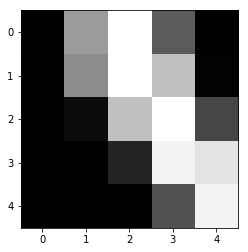

In [18]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

Tenga en cuenta que necesitamos pasar solo la matriz de 28x28 a `plt.imshow`, sin una dimensión de canal. También pasamos un mapa de colores (`cmap=gray`) para indicar que queremos ver una imagen en escala de grises.

## Conjuntos de datos de entrenamiento y validación

Al construir modelos de aprendizaje automático del mundo real, es bastante común dividir el conjunto de datos en tres partes:

1. **Conjunto de entrenamiento**: se utiliza para entrenar el modelo, es decir, calcular la pérdida y ajustar los pesos del modelo mediante el descenso de gradiente.
2. **Conjunto de validación**: se utiliza para evaluar el modelo durante el entrenamiento, ajustar los hiperparámetros (tasa de aprendizaje, etc.) y elegir la mejor versión del modelo.
3. **Conjunto de prueba**: se utiliza para comparar diferentes modelos o enfoques e informar sobre la precisión final del modelo.

En el conjunto de datos del MNIST, hay 60 000 imágenes de entrenamiento y 10 000 imágenes de prueba. El conjunto de prueba está estandarizado para que diferentes investigadores puedan informar los resultados de sus modelos contra la misma colección de imágenes.

Dado que no hay un conjunto de validación predefinido, debemos dividir manualmente las 60 000 imágenes en conjuntos de datos de entrenamiento y validación. Reservemos 10 000 imágenes elegidas al azar para la validación. Podemos hacer esto usando el método `random_spilt` de PyTorch.

In [19]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

Es esencial elegir una muestra aleatoria para crear un conjunto de validación. Los datos de entrenamiento a menudo se ordenan por las etiquetas de destino, es decir, imágenes de 0, seguidas de 1, seguidas de 2, etc. Si creamos un conjunto de validación utilizando el último 20% de las imágenes, solo constaría de 8 y 9. Por el contrario, el conjunto de entrenamiento no contendría 8 ni 9. Tal entrenamiento-validación haría imposible entrenar un modelo útil.

Ahora podemos crear cargadores de datos para ayudarnos a cargar los datos en lotes. Usaremos un tamaño de lote de 128.

In [20]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Configuramos `shuffle=True` para el cargador de datos de entrenamiento para garantizar que los lotes generados en cada época sean diferentes. Esta aleatorización ayuda a generalizar y acelerar el proceso de entrenamiento. Por otro lado, dado que el cargador de datos de validación se usa solo para evaluar el modelo, no es necesario mezclar las imágenes.

## Modelo

Ahora que hemos preparado nuestros cargadores de datos, podemos definir nuestro modelo.

*Un modelo de**regresión logística**es casi idéntico a un modelo de regresión lineal. Contiene matrices de ponderación y sesgo, y la salida se obtiene mediante operaciones matriciales simples (`pred = x @ w.t() + b`).* Como hicimos con la regresión lineal, podemos usar `nn.Linear` para crear el modelo en lugar de crear e inicializar manualmente las matrices.

*Dado que `nn.Linear` espera que cada ejemplo de entrenamiento sea un vector, cada tensor de imagen `1x28x28` se _aplana_ en un vector de tamaño 784 `(28*28)` antes de pasar al modelo.

* El resultado de cada imagen es un vector de tamaño 10, en el que cada elemento representa la probabilidad de una etiqueta de destino en particular (es decir, de 0 a 9). La etiqueta predicha para una imagen es simplemente la que tiene la probabilidad más alta.

In [24]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(in_features = input_size, out_features = num_classes)

Por supuesto, este modelo es mucho más grande que nuestro modelo anterior en términos de número de parámetros. Echemos un vistazo a los pesos y sesgos.

In [25]:
print(model)

Linear(in_features=784, out_features=10, bias=True)


In [26]:
model.bias
model.bias.shape

torch.Size([10])

In [27]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0272,  0.0254,  0.0070,  ...,  0.0271,  0.0071, -0.0239],
        [ 0.0008, -0.0183, -0.0132,  ..., -0.0297, -0.0195, -0.0028],
        [-0.0193, -0.0279,  0.0178,  ...,  0.0179, -0.0306, -0.0301],
        ...,
        [ 0.0315, -0.0104, -0.0265,  ..., -0.0106,  0.0091,  0.0350],
        [-0.0015,  0.0148, -0.0252,  ..., -0.0261,  0.0177, -0.0202],
        [ 0.0005,  0.0014, -0.0202,  ..., -0.0184,  0.0351, -0.0174]],
       requires_grad=True)

In [28]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0130,  0.0238,  0.0274,  0.0117,  0.0307, -0.0181,  0.0007, -0.0185,
        -0.0080,  0.0238], requires_grad=True)

Aunque hay un total de 7850 parámetros aquí, conceptualmente, nada ha cambiado hasta ahora. Probemos y generemos algunos resultados usando nuestro modelo. Tomaremos el primer lote de 100 imágenes de nuestro conjunto de datos y las pasaremos a nuestro modelo.

In [29]:
img, lb = train_ds[0]
img.shape

torch.Size([1, 28, 28])

In [30]:
train_loader

In [ ]:
list(train_loader)[:4]

In [35]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
#     outputs = model(images)
#     print(outputs)
    break

tensor([1, 3, 9, 3, 5, 3, 4, 3, 0, 6, 4, 5, 1, 1, 2, 7, 3, 6, 0, 2, 1, 9, 2, 5,
        0, 4, 7, 1, 9, 8, 0, 6, 6, 1, 3, 2, 5, 0, 3, 4, 0, 5, 9, 2, 4, 5, 5, 6,
        0, 0, 5, 2, 3, 7, 0, 4, 3, 0, 8, 8, 2, 2, 3, 4, 6, 1, 2, 8, 6, 2, 1, 4,
        0, 5, 5, 0, 9, 9, 4, 1, 9, 6, 6, 3, 3, 1, 3, 3, 5, 8, 3, 1, 5, 3, 4, 4,
        2, 7, 6, 7, 5, 0, 1, 9, 2, 3, 7, 9, 5, 1, 4, 5, 9, 3, 8, 7, 1, 0, 0, 9,
        5, 7, 3, 8, 7, 2, 3, 3])
torch.Size([128, 1, 28, 28])


In [37]:
images.shape

torch.Size([128, 1, 28, 28])

In [38]:
images.reshape(batch_size, 784).shape

torch.Size([128, 784])

El código anterior genera un error porque nuestros datos de entrada no tienen la forma correcta. Nuestras imágenes tienen la forma 1x28x28, pero necesitamos que sean vectores de tamaño 784, es decir, necesitamos aplanarlos. Usaremos el método `.reshape` de un tensor, que nos permitirá 'ver' eficientemente cada imagen como un vector plano sin realmente crear una copia de los datos subyacentes. Para incluir esta funcionalidad adicional dentro de nuestro modelo, necesitamos definir un modelo personalizado extendiendo la clase `nn.Module` de PyTorch.

Una clase en Python proporciona un "modelo" para crear objetos. Veamos un ejemplo de definición de una nueva clase en Python.

In [39]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
  
model = MnistModel()

Dentro del método constructor `__init__`, instanciamos los pesos y sesgos usando `nn.Linear`. Y dentro del método `forward`, que se invoca cuando pasamos un lote de entradas al modelo, aplanamos el tensor de entrada y lo pasamos a `self.linear`.

`xb.reshape(-1, 28*28)` indica a PyTorch que queremos una*vista*del tensor `xb` con dos dimensiones. La longitud a lo largo de la segunda dimensión es 28\*28 (es decir, 784). Un argumento para `.reshape` se puede establecer en `-1` (en este caso, la primera dimensión) para permitir que PyTorch lo descubra automáticamente en función de la forma del tensor original.

Tenga en cuenta que el modelo ya no tiene los atributos `.weight` y `.bias` (ya que ahora están dentro del atributo `.linear`), pero tiene un método `.parameters` que devuelve una lista que contiene los pesos y el sesgo .

In [40]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [41]:
model.linear.weight

Parameter containing:
tensor([[ 0.0203,  0.0183,  0.0007,  ..., -0.0008, -0.0156,  0.0218],
        [ 0.0298,  0.0048, -0.0126,  ...,  0.0071,  0.0040, -0.0052],
        [-0.0020,  0.0249, -0.0317,  ..., -0.0075, -0.0352,  0.0043],
        ...,
        [-0.0084, -0.0184, -0.0218,  ..., -0.0340, -0.0063,  0.0113],
        [ 0.0085,  0.0116, -0.0288,  ..., -0.0040, -0.0013, -0.0339],
        [ 0.0096, -0.0070,  0.0032,  ..., -0.0012,  0.0349, -0.0125]],
       requires_grad=True)

In [42]:
print(model.linear.weight.shape, model.linear.bias.shape)
model.parameters()
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0203,  0.0183,  0.0007,  ..., -0.0008, -0.0156,  0.0218],
         [ 0.0298,  0.0048, -0.0126,  ...,  0.0071,  0.0040, -0.0052],
         [-0.0020,  0.0249, -0.0317,  ..., -0.0075, -0.0352,  0.0043],
         ...,
         [-0.0084, -0.0184, -0.0218,  ..., -0.0340, -0.0063,  0.0113],
         [ 0.0085,  0.0116, -0.0288,  ..., -0.0040, -0.0013, -0.0339],
         [ 0.0096, -0.0070,  0.0032,  ..., -0.0012,  0.0349, -0.0125]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0191, -0.0302, -0.0273, -0.0281, -0.0226,  0.0268,  0.0181,  0.0354,
         -0.0002, -0.0301], requires_grad=True)]

Podemos usar nuestro nuevo modelo personalizado de la misma manera que antes. Veamos si funciona.

In [43]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2190, -0.0496,  0.0746, -0.0122, -0.1212, -0.3471, -0.2582,  0.0699,
         -0.2685,  0.2092],
        [ 0.2571, -0.0107, -0.1650,  0.1359,  0.0424, -0.3832,  0.1630,  0.0675,
         -0.6183,  0.1319]])


In [45]:
outputs

tensor([[ 0.2190, -0.0496,  0.0746,  ...,  0.0699, -0.2685,  0.2092],
        [ 0.2571, -0.0107, -0.1650,  ...,  0.0675, -0.6183,  0.1319],
        [ 0.1358, -0.1044,  0.0111,  ...,  0.2700, -0.1633, -0.0345],
        ...,
        [ 0.2713, -0.1081, -0.1103,  ...,  0.1579, -0.0792,  0.2572],
        [-0.0306, -0.2571, -0.1545,  ...,  0.3003,  0.0127,  0.1174],
        [ 0.3300, -0.1934, -0.0621,  ...,  0.3359, -0.3857,  0.1580]],
       grad_fn=<AddmmBackward>)

Para cada una de las 100 imágenes de entrada, obtenemos 10 salidas, una para cada clase. Como se discutió anteriormente, nos gustaría que estos resultados representen probabilidades. Los elementos de cada fila de salida deben estar entre 0 y 1 y sumar 1, lo cual no es el caso.

Para convertir las filas de salida en probabilidades, usamos la función softmax, que tiene la siguiente fórmula:

![softmax](https://i.imgur.com/EAh9jLN.png)

Primero, reemplazamos cada elemento `yi` en una fila de salida por `e^yi`, haciendo que todos los elementos sean positivos.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Luego, los dividimos por su suma para asegurarnos de que suman 1. El vector resultante puede interpretarse como probabilidades.



Si bien es fácil implementar la función softmax (¡debe probarla!), usaremos la implementación que se proporciona dentro de PyTorch porque funciona bien con tensores multidimensionales (una lista de filas de salida en nuestro caso).

In [63]:
import math

c = [-2., 7., 5., 9.]
print(c)
c_exp = [round(math.exp(i), 2) for i in c]
print(c_exp)
softmax = [(j/sum(c_exp)) for j in c_exp]
print(softmax)

import torch.nn.functional as F
import numpy as np
print(torch.as_tensor(c))
F.softmax(torch.as_tensor(c), dim=0)

[-2.0, 7.0, 5.0, 9.0]
[0.14, 1096.63, 148.41, 8103.08]
[1.4976049018747874e-05, 0.11730846168163916, 0.0158756816776598, 0.8668008805916823]
tensor([-2.,  7.,  5.,  9.])


tensor([1.4477e-05, 1.1731e-01, 1.5876e-02, 8.6680e-01])

In [64]:
import torch.nn.functional as F

La función softmax está incluida en el paquete `torch.nn.function` y requiere que especifiquemos una dimensión a lo largo de la cual se debe aplicar la función.

In [65]:
outputs[:3]

tensor([[ 0.2190, -0.0496,  0.0746, -0.0122, -0.1212, -0.3471, -0.2582,  0.0699,
         -0.2685,  0.2092],
        [ 0.2571, -0.0107, -0.1650,  0.1359,  0.0424, -0.3832,  0.1630,  0.0675,
         -0.6183,  0.1319],
        [ 0.1358, -0.1044,  0.0111,  0.1517,  0.1973, -0.2435, -0.1137,  0.2700,
         -0.1633, -0.0345]], grad_fn=<SliceBackward>)

tenemos 10 salidas para 128 imágenes (lote).

In [73]:
outputs.shape

torch.Size([128, 10])

![](https://miro.medium.com/max/700/0*fr4sfcnDc0KsXA8P.png)

In [107]:
a = np.array([[1,1,1], [2,2,2]])
print(a)
print(a.sum(axis=0))
print(a.sum(axis=1))
print(a[:,0])
print(a[0])
print(a[0,:])

[[1 1 1]
 [2 2 2]]
[3 3 3]
[3 6]
[1 2]
[1 1 1]
[1 1 1]


In [98]:
print(outputs.shape)
print(F.softmax(outputs, dim=1).sum(axis=1))
print("\n")
print(F.softmax(outputs, dim=0).sum(axis=0))

torch.Size([128, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.

In [84]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

In [90]:
probs[0]

tensor([0.1284, 0.0981, 0.1111, 0.1019, 0.0914, 0.0729, 0.0797, 0.1106, 0.0788,
        0.1271], grad_fn=<SelectBackward>)

In [108]:
# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1284, 0.0981, 0.1111, 0.1019, 0.0914, 0.0729, 0.0797, 0.1106, 0.0788,
         0.1271],
        [0.1303, 0.0997, 0.0854, 0.1154, 0.1051, 0.0687, 0.1186, 0.1078, 0.0543,
         0.1149]])
Sum:  0.9999998807907104


Finalmente, podemos determinar la etiqueta predicha para cada imagen simplemente eligiendo el índice del elemento con la probabilidad más alta en cada fila de salida. Podemos hacer esto usando `torch.max`, que devuelve el elemento más grande de cada fila y el índice correspondiente.

In [111]:
max_probs, preds = torch.max(probs[:2], dim=1)
print(preds)
print(max_probs)

tensor([0, 0])
tensor([0.1284, 0.1303], grad_fn=<MaxBackward0>)


In [114]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 0, 7, 3, 7, 3, 0, 3, 6, 3, 9, 3, 0, 7, 6, 7, 7, 9, 0, 3, 3, 9, 9, 3,
        9, 7, 3, 9, 7, 3, 0, 3, 9, 7, 7, 0, 0, 3, 0, 3, 3, 0, 7, 6, 7, 0, 7, 4,
        0, 3, 9, 9, 9, 0, 0, 0, 3, 0, 6, 9, 9, 7, 3, 9, 3, 6, 9, 3, 9, 0, 0, 3,
        9, 0, 6, 0, 3, 9, 6, 7, 9, 0, 6, 3, 9, 7, 0, 3, 3, 3, 3, 6, 0, 0, 9, 3,
        7, 4, 9, 3, 6, 0, 7, 7, 6, 6, 9, 7, 0, 0, 9, 7, 0, 9, 7, 0, 9, 3, 0, 9,
        6, 9, 0, 6, 0, 0, 7, 7])
tensor([0.1284, 0.1303, 0.1279, 0.1646, 0.1446, 0.1247, 0.1309, 0.1304, 0.1168,
        0.1262, 0.1311, 0.1348, 0.1226, 0.1286, 0.1290, 0.1308, 0.1365, 0.1402,
        0.1334, 0.1496, 0.1278, 0.1408, 0.1220, 0.1240, 0.1402, 0.1419, 0.1375,
        0.1193, 0.1208, 0.1503, 0.1325, 0.1407, 0.1487, 0.1294, 0.1537, 0.1301,
        0.1318, 0.1449, 0.1186, 0.1189, 0.1378, 0.1347, 0.1287, 0.1297, 0.1450,
        0.1541, 0.1425, 0.1224, 0.1235, 0.1480, 0.1701, 0.1385, 0.1539, 0.1290,
        0.1370, 0.1264, 0.1346, 0.1346, 0.1262, 0.1475, 0.1373, 0.1309, 0.1403,
       

Esto está mal, solo para probar la función.

In [112]:
aux1, aux2 = torch.max(probs[:2], dim=0)
print(aux1)
print(aux2)

tensor([0.1303, 0.0997, 0.1111, 0.1154, 0.1051, 0.0729, 0.1186, 0.1106, 0.0788,
        0.1271], grad_fn=<MaxBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 0])


Los números impresos arriba son las etiquetas predichas para el primer lote de imágenes de entrenamiento. Vamos a compararlos con las etiquetas reales.

In [116]:
labels

tensor([5, 7, 6, 6, 6, 1, 8, 1, 7, 9, 7, 4, 6, 5, 1, 5, 5, 0, 8, 2, 1, 0, 6, 1,
        7, 5, 4, 4, 2, 1, 4, 7, 9, 3, 3, 0, 8, 2, 4, 8, 6, 9, 9, 1, 5, 2, 6, 7,
        9, 7, 0, 0, 0, 6, 8, 6, 4, 5, 5, 0, 0, 8, 6, 0, 5, 1, 0, 9, 0, 4, 6, 1,
        0, 4, 9, 6, 3, 0, 1, 5, 4, 6, 1, 5, 0, 8, 6, 1, 8, 4, 8, 7, 0, 3, 3, 2,
        6, 1, 7, 4, 1, 6, 3, 3, 1, 1, 0, 3, 3, 1, 0, 8, 4, 7, 8, 5, 5, 5, 4, 7,
        1, 7, 8, 1, 4, 0, 0, 6])

La mayoría de las etiquetas previstas son diferentes de las etiquetas reales. Esto se debe a que comenzamos con pesos y sesgos inicializados aleatoriamente. Necesitamos entrenar el modelo, es decir, ajustar los pesos usando el gradiente descendente para hacer mejores predicciones.

## Métrica de evaluación y función de pérdida
Al igual que con la regresión lineal, necesitamos una forma de evaluar qué tan bien está funcionando nuestro modelo. Una forma natural de hacer esto sería encontrar el porcentaje de etiquetas que se predijeron correctamente, es decir,. la **precisión** de las predicciones.

In [117]:
outputs[:2]

tensor([[ 0.2190, -0.0496,  0.0746, -0.0122, -0.1212, -0.3471, -0.2582,  0.0699,
         -0.2685,  0.2092],
        [ 0.2571, -0.0107, -0.1650,  0.1359,  0.0424, -0.3832,  0.1630,  0.0675,
         -0.6183,  0.1319]], grad_fn=<SliceBackward>)

In [120]:
torch.sum(preds == labels)

tensor(5)

In [121]:
torch.sum(preds == labels).item()

5

In [122]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

El operador `==` realiza una comparación por elementos de dos tensores con la misma forma y devuelve un tensor de la misma forma, que contiene `Verdadero` para elementos desiguales y `Falso` para elementos iguales. Pasar el resultado a `torch.sum` devuelve el número de etiquetas que se predijeron correctamente. Finalmente, dividimos por el número total de imágenes para obtener la precisión.

Tenga en cuenta que no necesitamos aplicar softmax a las salidas ya que sus resultados tienen el mismo orden relativo. Esto se debe a que `e^x` es una función creciente, es decir, si `y1 > y2`, entonces `e^y1 > e^y2`. Lo mismo ocurre después de promediar los valores para obtener el softmax.

Calculemos la precisión del modelo actual en el primer lote de datos.

In [123]:
accuracy(outputs, labels)

tensor(0.0391)

In [124]:
probs

tensor([[0.1284, 0.0981, 0.1111,  ..., 0.1106, 0.0788, 0.1271],
        [0.1303, 0.0997, 0.0854,  ..., 0.1078, 0.0543, 0.1149],
        [0.1118, 0.0880, 0.0987,  ..., 0.1279, 0.0829, 0.0943],
        ...,
        [0.1266, 0.0866, 0.0864,  ..., 0.1130, 0.0892, 0.1248],
        [0.1014, 0.0808, 0.0896,  ..., 0.1411, 0.1059, 0.1175],
        [0.1301, 0.0771, 0.0879,  ..., 0.1308, 0.0636, 0.1095]],
       grad_fn=<SoftmaxBackward>)

La precisión es una forma excelente para nosotros (los humanos) de evaluar el modelo. Sin embargo, no podemos usarla como una función de pérdida para optimizar nuestro modelo mediante el descenso de gradiente por las siguientes razones:

1. No es una función diferenciable. `torch.max` y `==` son operaciones no continuas y no diferenciables, por lo que no podemos usar la precisión para calcular gradientes con los pesos y sesgos.

2. No tiene en cuenta las probabilidades reales predichas por el modelo, por lo que no puede proporcionar suficiente retroalimentación para mejoras incrementales.

Por estas razones, la precisión se usa a menudo como una **métrica de evaluación** para la clasificación, pero no como una función de pérdida. Una función de pérdida comúnmente utilizada para problemas de clasificación es la **entropía cruzada**, que tiene la siguiente fórmula:

![entropía cruzada](https://i.imgur.com/VDRDl1D.png)

Si bien parece complicado, en realidad es bastante simple:

*Para cada fila de salida, elija la probabilidad pronosticada para la etiqueta correcta. Por ejemplo, si las probabilidades pronosticadas para una imagen son `[0.1, 0.3, 0.2, ...]` y la etiqueta correcta es `1`, elegimos el elemento correspondiente `0.3` e ignoramos el resto.* Luego, toma el [logaritmo](https://en.wikipedia.org/wiki/Logarithm) de la probabilidad seleccionada. Si la probabilidad es alta, es decir, cercana a 1, entonces su logaritmo es un valor negativo muy pequeño, cercano a 0. Y si la probabilidad es baja (cerca de 0), entonces el logaritmo es un valor negativo muy grande. También multiplicamos el resultado por -1, lo que da como resultado un gran valor positivo de la pérdida por malas predicciones.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finalmente, tome el promedio de la entropía cruzada en todas las filas de salida para obtener la pérdida total de un lote de datos.

A diferencia de la precisión, la entropía cruzada es una función continua y diferenciable. También proporciona retroalimentación útil para mejoras incrementales en el modelo (una probabilidad ligeramente mayor para la etiqueta correcta conduce a una pérdida menor). Estos dos factores hacen que la entropía cruzada sea una mejor opción para la función de pérdida.

Como era de esperar, PyTorch proporciona una implementación de entropía cruzada eficiente y compatible con tensores como parte del paquete `torch.nn.funcional`. Además, también realiza softmax internamente, por lo que podemos pasar directamente los resultados del modelo sin convertirlos en probabilidades.

In [126]:
outputs

tensor([[ 0.2190, -0.0496,  0.0746,  ...,  0.0699, -0.2685,  0.2092],
        [ 0.2571, -0.0107, -0.1650,  ...,  0.0675, -0.6183,  0.1319],
        [ 0.1358, -0.1044,  0.0111,  ...,  0.2700, -0.1633, -0.0345],
        ...,
        [ 0.2713, -0.1081, -0.1103,  ...,  0.1579, -0.0792,  0.2572],
        [-0.0306, -0.2571, -0.1545,  ...,  0.3003,  0.0127,  0.1174],
        [ 0.3300, -0.1934, -0.0621,  ...,  0.3359, -0.3857,  0.1580]],
       grad_fn=<AddmmBackward>)

In [127]:
loss_fn = F.cross_entropy

In [128]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3799, grad_fn=<NllLossBackward>)


Sabemos que la entropía cruzada es el logaritmo negativo de la probabilidad predicha de la etiqueta correcta promediada sobre todas las muestras de entrenamiento. Por lo tanto, una forma de interpretar el número resultante, p. `2.23` es mirar `e^-2.23` que es alrededor de `0.1` como la probabilidad predicha de la etiqueta correcta, en promedio. *Cuanto menor sea la pérdida, mejor será el modelo.*

In [134]:
print(math.exp(-loss.item()))
print(math.exp(-10))
print(math.exp(-2))
print(math.exp(-1))
print(math.exp(-0.2))

0.09255626006372962
4.5399929762484854e-05
0.1353352832366127
0.36787944117144233
0.8187307530779818


## Entrenando al modelo

Ahora que hemos definido los cargadores de datos, el modelo, la función de pérdida y el optimizador, estamos listos para entrenar el modelo. El proceso de entrenamiento es idéntico a la regresión lineal, con la adición de una "fase de validación" para evaluar el modelo en cada época. Así es como se ve en pseudocódigo:

```
for epoch in range(num_epochs):
    # Fase de entrenamiento
    for batch in train_loader:
        # Generar predicciones
        # Calcular pérdida
        # Calcular gradientes
        # Actualizar pesos
        # Restablecer gradientes
    
    # Fase de validación
    for batch in val_loader:
        # Generar predicciones
        # Calcular pérdida
        # Calcular métricas (precisión, etc.)
    # Calcule la pérdida de validación promedio y las métricas
    
    # Época de registro, pérdida y métricas para inspección
```

Algunas partes del ciclo de entrenamiento son específicas del problema específico que estamos resolviendo (por ejemplo, función de pérdida, métricas, etc.), mientras que otras son genéricas y se pueden aplicar a cualquier problema de aprendizaje profundo.

Incluiremos las partes independientes del problema dentro de una función llamada `fit`, que se usará para entrenar el modelo. Las partes específicas del problema se implementarán agregando nuevos métodos a la clase `nn.Module`.

In [135]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

La función `fit` registra la pérdida de validación y la métrica de cada época. Devuelve un historial de la formación, útil para la depuración y visualización.

Las configuraciones como el tamaño del lote, la tasa de aprendizaje, etc. (llamadas hiperparámetros), deben elegirse con anticipación mientras se entrenan los modelos de aprendizaje automático. Elegir los hiperparámetros correctos es fundamental para entrenar un modelo razonablemente preciso en un tiempo razonable. Es un área activa de investigación y experimentación en aprendizaje automático. Siéntase libre de probar diferentes tasas de aprendizaje y ver cómo afecta el proceso de capacitación.


Definamos la función `evaluate`, utilizada en la fase de validación de `fit`.

In [136]:
l1 = [1, 2, 3, 4, 5]

In [137]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finalmente, redefinamos la clase `MnistModel` para incluir los métodos adicionales `training_step`, `validation_step`, `validation_epoch_end` y `epoch_end` usados ​​por `fit` y `evaluar`.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Antes de entrenar el modelo, veamos cómo funciona el modelo en el conjunto de validación con el conjunto inicial de pesos y sesgos inicializados aleatoriamente.

In [ ]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.10977056622505188, 'val_loss': 2.3349318504333496}

La precisión inicial es de alrededor del 10 %, lo que cabría esperar de un modelo inicializado aleatoriamente (ya que tiene una probabilidad de 1 en 10 de obtener una etiqueta correcta adivinando aleatoriamente).

Ahora estamos listos para entrenar el modelo. Entrenemos durante cinco épocas y veamos los resultados.

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9552, val_acc: 0.6153
Epoch [1], val_loss: 1.6839, val_acc: 0.7270
Epoch [2], val_loss: 1.4819, val_acc: 0.7587
Epoch [3], val_loss: 1.3295, val_acc: 0.7791
Epoch [4], val_loss: 1.2124, val_acc: 0.7969


¡Es un gran resultado! Con solo 5 épocas de entrenamiento, nuestro modelo ha alcanzado una precisión de más del 80 % en el conjunto de validación. Veamos si podemos mejorar eso entrenando para algunas épocas más. Intente cambiar las tasas de aprendizaje y el número de épocas en cada una de las celdas a continuación.

In [ ]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1205, val_acc: 0.8081
Epoch [1], val_loss: 1.0467, val_acc: 0.8165
Epoch [2], val_loss: 0.9862, val_acc: 0.8237
Epoch [3], val_loss: 0.9359, val_acc: 0.8281
Epoch [4], val_loss: 0.8934, val_acc: 0.8322


In [ ]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8569, val_acc: 0.8371
Epoch [1], val_loss: 0.8254, val_acc: 0.8393
Epoch [2], val_loss: 0.7977, val_acc: 0.8420
Epoch [3], val_loss: 0.7733, val_acc: 0.8447
Epoch [4], val_loss: 0.7515, val_acc: 0.8470


In [ ]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7320, val_acc: 0.8494
Epoch [1], val_loss: 0.7144, val_acc: 0.8512
Epoch [2], val_loss: 0.6985, val_acc: 0.8528
Epoch [3], val_loss: 0.6839, val_acc: 0.8543
Epoch [4], val_loss: 0.6706, val_acc: 0.8557


Si bien la precisión continúa aumentando a medida que entrenamos para más épocas, las mejoras se reducen con cada época. Visualicemos esto usando un gráfico de líneas.

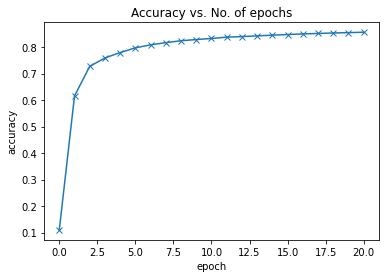

In [ ]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Está bastante claro en la imagen de arriba que el modelo probablemente no cruzará el umbral de precisión del 90%, incluso después de entrenar durante mucho tiempo. Una posible razón de esto es que la tasa de aprendizaje puede ser demasiado alta. Los parámetros del modelo pueden estar "rebotando" alrededor del conjunto óptimo de parámetros para la pérdida más baja. Puede intentar reducir la tasa de aprendizaje y el entrenamiento durante algunas épocas más para ver si ayuda.

La razón más probable de que **el modelo simplemente no sea lo suficientemente potente**. Si recuerdas nuestra hipótesis inicial, hemos asumido que la salida (en este caso las probabilidades de clase) es una **función lineal** de la entrada (intensidades de píxeles), obtenida al realizar una multiplicación matricial con los pesos matriz y sumando el sesgo. Esta es una suposición bastante débil, ya que es posible que en realidad no exista una relación lineal entre las intensidades de los píxeles en una imagen y el dígito que representa. Si bien funciona razonablemente bien para un conjunto de datos simple como MNIST (lo que nos brinda una precisión del 85 %), necesitamos modelos más sofisticados que puedan capturar relaciones no lineales entre los píxeles de la imagen y las etiquetas para tareas complejas como reconocer objetos cotidianos, animales, etc.

## Pruebas con imágenes individuales

Si bien hasta ahora hemos estado rastreando la precisión general de un modelo, también es una buena idea observar los resultados del modelo en algunas imágenes de muestra. Probemos nuestro modelo con algunas imágenes del conjunto de datos de prueba predefinido de 10000 imágenes. Comenzamos recreando el conjunto de datos de prueba con la transformación `ToTensor`.

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Aquí hay una imagen de muestra del conjunto de datos.

Shape: torch.Size([1, 28, 28])
Label: 7


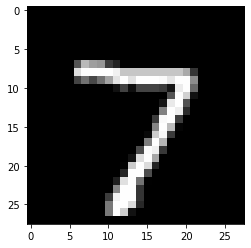

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Definamos una función auxiliar `predict_image`, que devuelve la etiqueta pronosticada para un solo tensor de imagen.

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simplemente agrega otra dimensión al comienzo del tensor 1x28x28, convirtiéndolo en un tensor 1x1x28x28, que el modelo ve como un lote que contiene una sola imagen.

Vamos a probarlo con algunas imágenes.

Label: 7 , Predicted: 7


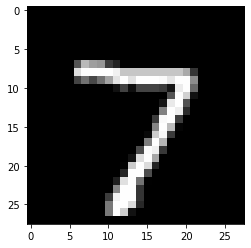

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


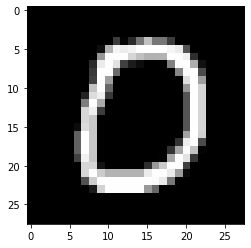

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


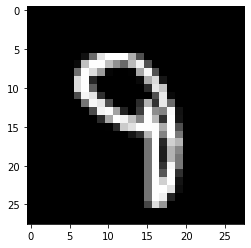

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


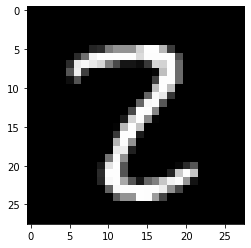

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identificar dónde funciona mal nuestro modelo puede ayudarnos a mejorar el modelo mediante la recopilación de más datos de entrenamiento, el aumento o la disminución de la complejidad del modelo y el cambio de los parámetros exagerados.

Como paso final, veamos también la pérdida general y la precisión del modelo en el conjunto de prueba.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.86083984375, 'val_loss': 0.6424765586853027}

Esperamos que esto sea similar a la precisión/pérdida en el conjunto de validación. De lo contrario, es posible que necesitemos un mejor conjunto de validación que tenga datos y una distribución similares a los del conjunto de prueba (que a menudo proviene de datos del mundo real).

## Saving and loading the model

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

El método `.state_dict` devuelve un `OrderedDict` que contiene todas las matrices de ponderación y sesgo asignadas a los atributos correctos del modelo.

In [ ]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0057,  0.0222, -0.0220,  ..., -0.0021, -0.0115, -0.0308],
                      [-0.0353,  0.0083, -0.0307,  ...,  0.0345, -0.0087,  0.0200],
                      [ 0.0104,  0.0158,  0.0225,  ...,  0.0255,  0.0227, -0.0346],
                      ...,
                      [-0.0097, -0.0173, -0.0154,  ...,  0.0025, -0.0274, -0.0276],
                      [ 0.0272, -0.0156,  0.0029,  ...,  0.0217,  0.0286, -0.0114],
                      [-0.0018, -0.0293, -0.0191,  ..., -0.0297,  0.0291,  0.0212]])),
             ('linear.bias',
              tensor([-0.0322,  0.1078, -0.0008, -0.0159,  0.0346,  0.0235, -0.0047,  0.0277,
                      -0.0684, -0.0356]))])

Para cargar los pesos del modelo, podemos instanciar un nuevo objeto de la clase `MnistModel` y usar el método `.load_state_dict`.

In [ ]:
model2 = MnistModel()

In [ ]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0168, -0.0088, -0.0010,  ..., -0.0233,  0.0253,  0.0161],
                      [-0.0139, -0.0039,  0.0011,  ...,  0.0178, -0.0125, -0.0090],
                      [-0.0341, -0.0001,  0.0089,  ..., -0.0282,  0.0181,  0.0251],
                      ...,
                      [-0.0274, -0.0289, -0.0180,  ..., -0.0197, -0.0173,  0.0262],
                      [ 0.0318,  0.0125,  0.0178,  ..., -0.0192,  0.0083, -0.0032],
                      [-0.0264, -0.0261,  0.0058,  ..., -0.0005,  0.0135,  0.0287]])),
             ('linear.bias',
              tensor([ 0.0014, -0.0254, -0.0085, -0.0081, -0.0333,  0.0109, -0.0128, -0.0342,
                       0.0204,  0.0232]))])

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.08339843899011612, 'val_loss': 2.325232744216919}

In [ ]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0057,  0.0222, -0.0220,  ..., -0.0021, -0.0115, -0.0308],
                      [-0.0353,  0.0083, -0.0307,  ...,  0.0345, -0.0087,  0.0200],
                      [ 0.0104,  0.0158,  0.0225,  ...,  0.0255,  0.0227, -0.0346],
                      ...,
                      [-0.0097, -0.0173, -0.0154,  ...,  0.0025, -0.0274, -0.0276],
                      [ 0.0272, -0.0156,  0.0029,  ...,  0.0217,  0.0286, -0.0114],
                      [-0.0018, -0.0293, -0.0191,  ..., -0.0297,  0.0291,  0.0212]])),
             ('linear.bias',
              tensor([-0.0322,  0.1078, -0.0008, -0.0159,  0.0346,  0.0235, -0.0047,  0.0277,
                      -0.0684, -0.0356]))])

Solo como una verificación de cordura, verifiquemos que este modelo tenga la misma pérdida y precisión en el conjunto de prueba que antes.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.86083984375, 'val_loss': 0.6424765586853027}

Como paso final, podemos guardar y confirmar nuestro trabajo utilizando la biblioteca `jovian`. Junto con el cuaderno, también podemos acoplar las pesas de nuestro modelo entrenado, para poder utilizarlo más adelante.

## Otras lecturas


Aquí hay algunas referencias para leer más:
*Para un tratamiento más matemático, consulte el popular curso [Aprendizaje automático](https://www.coursera.org/lecture/machine-learning/classification-wlPeP) en Coursera. La mayoría de las imágenes utilizadas en esta serie de tutoriales han sido tomadas de este curso.* El ciclo de entrenamiento definido en este cuaderno se inspiró en [Cuadernos de desarrollo de FastAI](https://github.com/fastai/fastai_docs/blob/master/dev_nb/001a_nn_basics.ipynb) que contienen una gran cantidad de otras cosas útiles si puede leer y comprender el código.
* Para una inmersión profunda en softmax y entropía cruzada, consulte [esta publicación de blog en DeepNotes] (https://deepnotes.io/softmax-crossentropy).